In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import sklearn.metrics as skm

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [18]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')



In [19]:
# extract labels and remove from data
labels = data[:, 0]
data = data[:, 1:]


# normalize
dataNorm = data/np.max(data)

In [20]:
where7s = np.where(labels == 7)[0]

# how many to remove, to leave 500 in the data
N2remove = where7s.shape[0] - 500

# pick that number of 7's at random
remove7s = np.random.choice(where7s, size = N2remove, replace = False)


dataNorm = np.delete(dataNorm, remove7s, axis = 0)
labels = np.delete(labels, remove7s)

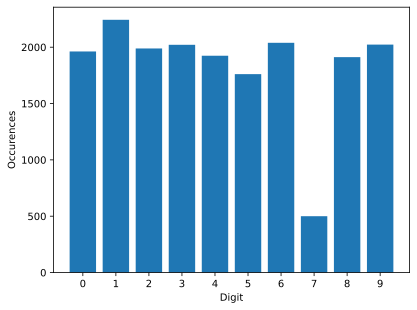

In [21]:
plt.bar(np.unique(labels, return_counts = True)[0], np.unique(labels, return_counts = True)[1])
plt.xlabel('Digit')
plt.ylabel('Occurences')
plt.xticks(range(10))
plt.show()

In [22]:
# step 1 : convert to tensor
dataT = torch.tensor(dataNorm).float()
labels = torch.tensor(labels).long()

# step 2 : splitting the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .1)

# step 3 : convert tensor datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4 : dataloaders
train_loader = DataLoader(train_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [23]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()


            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer
            self.output = nn.Linear(32, 10)

        def forward(self, X):

            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            X = f.relu(self.fc2(X))

            return self.output(X)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = .01)

    return net, lossfun, optimizer






In [24]:
def function2trainTheModel():

    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # losses
    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc = []


    for epochi in range(numepochs):
        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # matches
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            batchAcc.append(accuracypct)

        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            testAcc.append(accuracypct)

    return trainAcc, testAcc, losses, net


In [25]:
trainAcc, testAcc, losses, net = function2trainTheModel()

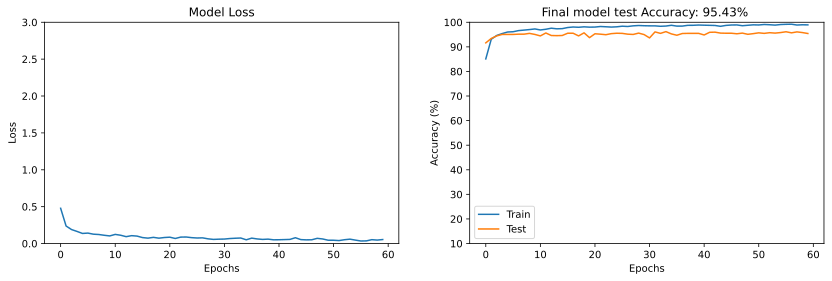

In [26]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label = 'Train')
ax[1].plot(testAcc, label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test Accuracy: {testAcc[-1]:.2f}% ')
ax[1].legend()

plt.show()

In [27]:
# predictions from train data
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat, axis = 1)

# predictions from test data
yHat = net(test_loader. dataset.tensors[0])
test_predictions = torch.argmax(yHat, axis = 1)
test_predictions

tensor([3, 4, 8,  ..., 4, 4, 2])

In [28]:
# intialize vectors
train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1], train_predictions)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average = 'weighted')
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1], train_predictions, average = 'weighted')
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1], train_predictions, average = 'weighted')


# testing
test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1], test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average = 'weighted')
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average = 'weighted')
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1], test_predictions, average = 'weighted')



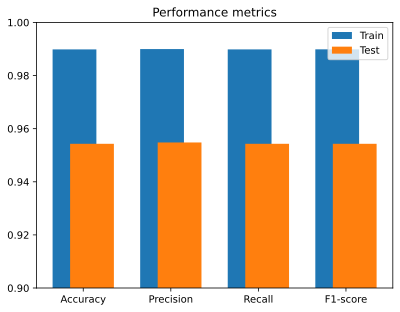

In [29]:
plt.bar(np.arange(4) - .1, train_metrics, .5)
plt.bar(np.arange(4) + .1, test_metrics, .5)
plt.xticks([0, 1, 2, 3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([.9, 1])
plt.legend(['Train', 'Test'])
plt.title('Performance metrics')
plt.show()

In [30]:
precision = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average = None)
recall    = skm.recall_score(test_loader.dataset.tensors[1],test_predictions, average = None)

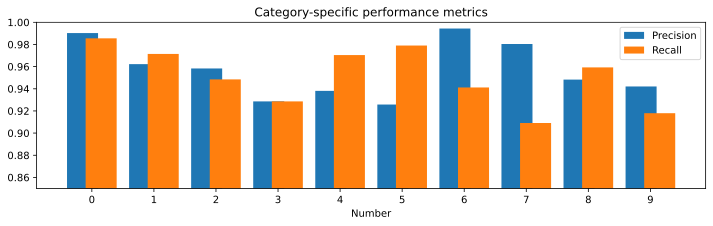

In [31]:
# plotting class wise precision recall
fig = plt.figure(figsize = (12, 3))
plt.bar(np.arange(10)-.15, precision, .5)
plt.bar(np.arange(10)+.15, recall, .5)
plt.xticks(range(10), range(10))
plt.ylim([.85, 1])
plt.xlabel('Number')
plt.legend(['Precision', 'Recall'])
plt.title('Category-specific performance metrics')
plt.show()

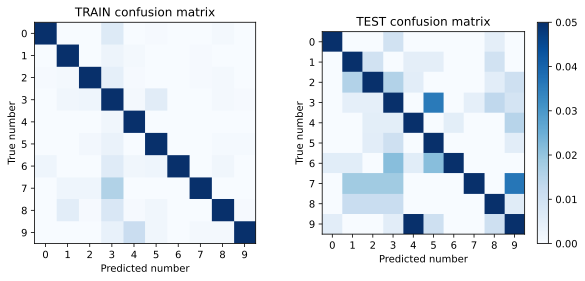

In [32]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions,normalize='true')
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions,normalize='true')

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()